# ML I: Introduction to Unsupervised Machine Learning #

**In the prelab, you learned about the different types of machine learning and what each can be useful for.**

Now, we'll meet our first machine learning algorithm: **k-means clustering.** K-means has many applications, but has been used to identify subtypes of disease from genomic data. Watch Casey Greene's introduction to k-means video, in which he discusses [this paper by Tothill et al.](https://pubmed.ncbi.nlm.nih.gov/18698038/)

**K-means Introduction:** https://youtu.be/qL7TBaMtooM


Question: In 4 sentences or fewer (or if you prefer, 4 bulletpoints), summarize how the k-means algorithm works.

### k-Means Demo Code

Now, we'll actually use some code that will perform k-means clustering. First, we load the necessary R packages into our environment:

In [4]:
library(ggplot2)
library(RColorBrewer)
options(repr.plot.width=10, repr.plot.height=3) #set size for plots in this notebook

Warning message:
“package ‘ggplot2’ was built under R version 3.6.2”


The next function is used to assign an observation (point) to the centroid closest to it. 

In [9]:
assign_nearest <- function(centroids, point){
  # Assigns point to its closest centroid
  # Inputs: 
  #   centroids-- list of centroids, where each is a vector c(x_location, y_location)
  #   point -- vector describing location of input point c(x_location, y_location)
  # Outputs: 
  #   Index of closest centroid to the point
  
  nearestindex = 1
  nearestdist = .Machine$double.xmax # largest float number
  
  # point coordinates
  x2 = point[1]
  y2 = point[2]
  
  for (i in 1:length(centroids)){
    # Centroid coordinates
    x1 = centroids[[i]][1]
    y1 = centroids[[i]][2]
    
    dist = sqrt((x1-x2)^2 + (y1-y2)^2) # Euclidean distance between point and centroid
    if(dist < nearestdist){
      nearestindex = i
      nearestdist = dist
    }
  }
  return(nearestindex)
}

The next function actually performs k-means clustering. You need to understand how the algorithm works at the level of the video lecture. You don't need to understand every line of this, but you should feel free to dive in if you're interested!

In [10]:
kmeans_function <- function(data, k){
  # Performs k-means clustering for two-dimensional data
  # Inputs:
  #   data -- array object containing columns X and Y containing x and y
  #           coordinates of points in the population, respectively 
  #   k -- the number of clusters to find
  # Outputs:
  #   a list of 3 elements: 
  #   'centroids' -- vector of final centroid positions
  #   'members' -- a list (with one entry per centroid) of vectors containing 
  #                points belonging to each centroid at the end of clustering
  #   'paths' -- a list (with one entry per centroid) of vectors containing 
  #              the points occupied by each centroid
  
  if(length(dim(data)) != 2){
    print("ERROR: Please enter a two-dimensional dataframe")
  }
  colnames(data) = c("X", "Y")
  
  centroids = list()
  centroidSumsEmpty = list()
  randomrows = sample(1:nrow(data), k) # Randomly sample k rows as initial centroids
  for (i in 1:k){
    centroids[[i]] = data[randomrows[i], ]
    centroidSumsEmpty[[i]] = c(0,0)
  }
  
  paths=list()
  paths_Index = 1
  pstates_Index = 1
  previous_states = c()
  centroidsflattened = as.vector(unlist(centroids))
  
  # continue until we see a set of centroids we've seen before
  while(!(list(centroidsflattened) %in% previous_states)){
    previous_states[[pstates_Index]] = centroidsflattened
    
    # Make assignments based on closeness to current centroids
    assignments = c()
    for(r in 1:nrow(data)){
      point = data[r, ]
      assignments = append(assignments, assign_nearest(centroids, point))
    }
    
    # Initialize 0,0 sums for each centroid's coordinates
    centroidSums = centroidSumsEmpty
    # Intialize counts of members belonging to each centroid
    centroidN = rep(0, k)
    
    # Increment centroid counts and sums based on assigned points 
    for(i in 1:length(assignments)){
      centroid = assignments[i]
      centroidN[centroid] = centroidN[centroid] + 1
      centroidSums[[centroid]] = centroidSums[[centroid]] + data[i,]
    }
    
    # Get average locations of points in each centroid to get  
    # new centroid coordinates
    for(i in 1:k){
      newcentroid = centroidSums[[i]] / centroidN[i]
      centroids[[i]] = newcentroid
      
      paths[[paths_Index]] = append(i, newcentroid)
      paths_Index = paths_Index + 1

    }
    
    
    centroidsflattened = as.vector(unlist(centroids))
    pstates_Index = pstates_Index + 1 # increment previous states index so we can keep adding them
  }
 
  
  outputlist = list()
  outputlist$centroids = centroids
  outputlist$paths = do.call(rbind, paths)
  outputlist$members = assignments
  return(outputlist)
}

Finally, we'll need a function to plot the output of our k-means clustering. This function uses ggplot2 to show the points (colored by the cluster they're assigned to), the centroids of each cluster, and the paths the centroids took along the way. 

In [11]:
plot_km <- function(km, data){
  # Plots the results of the kmeans_function()
  # Inputs:
  #   km -- returned output object of kmeans_function() 
  #   data -- 2 dimensional dataframe used in kmeans_function() where rows are points,
  #           columns are X, Y coordinates of those points
  # Outputs: 
  #   Displays ggplot showing points in the population colored by cluster assignment, 
  #   designating centroids + their paths 
  k=length(km$centroids)
  
  # Get the appropriate number of colors to use in the plot (one for each centroid)
  cluster_colors = brewer.pal(k, "Dark2")
  
  # Dataframe representing centroids themselves 
  centroidsDF = do.call(rbind, km$centroids)
  centroidsDF$CentroidIndex = 1:k 
  centroidsDF$size=1
  centroidsDF$shape = 4
  # Dataframe representing paths of centroids, labeled by CentroidIndex
  paths = data.frame(km$paths)
  colnames(paths) = c("CentroidIndex", "X", "Y")
  paths = data.frame(apply(paths, 2, unlist ))
  paths$CentroidIndex = as.factor(paths$CentroidIndex)
  paths$shape = 1
  
  # Dataframe representing the points, labeled by CentroidIndex
  points = data
  points$CentroidIndex = km$members
  colnames(points) = c("X", "Y", "CentroidIndex")
  points$size = .5
  points$shape = 1
  
  # Define axes for plot 
  xmin = min(points$X)
  xmax = max(points$X)
  xstart = xmin - abs(xmax - xmin)*.1
  xstop= xmax + abs(xmax - xmin)*.1
  
  ymin = min(points$Y)
  ymax = max(points$Y)
  ystart = min(points$Y) - abs(ymax - ymin)*.1
  yend = max(points$Y) + abs(ymax - ymin)*.1
  
  centroidsDF$size=.4
  centroidsDF$shape = 6
  plot1 = ggplot(data=points, aes(x=X, y=Y, color=factor(CentroidIndex),  shape=factor(shape),  fill=factor(CentroidIndex))) + geom_point() + geom_point(data=centroidsDF, aes(x=X, y=Y, color=factor(CentroidIndex), size=size, shape=factor(shape), fill=factor(CentroidIndex))) + geom_line(data=paths, aes(x=X, y=Y, color=factor(CentroidIndex))) + scale_color_manual(values=cluster_colors)  + scale_shape_manual(values=c(16,4)) + theme(legend.position="none")

  return(plot1)
}


Let's load some data in and give it a try! Make sure you've run the above cells before you try this. If you run the 2nd and 3rd steps multiple times, you'll get slightly different results each time. 

In [15]:
# Load in the data located in this directory
KMeansPop = read.csv("kmeans-population.csv", header=F)

In [16]:
# Call the k-means function with k=3
kmeansobject = kmeans_function(KMeansPop, 3)

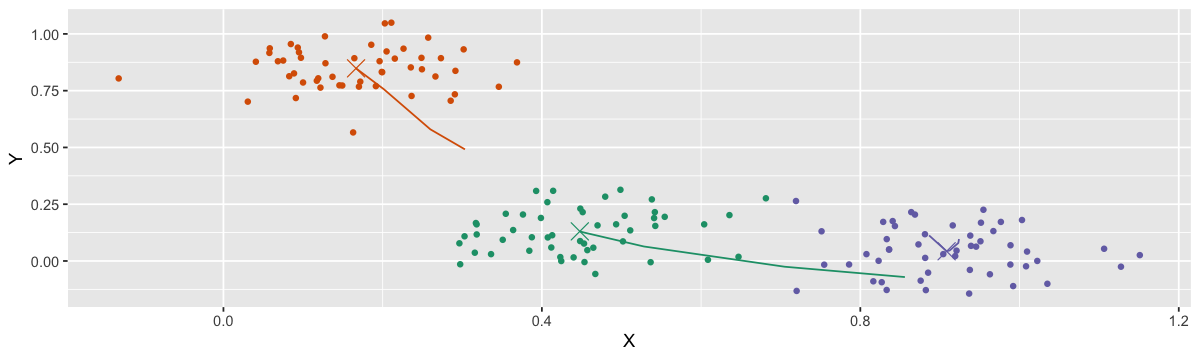

In [17]:
# Plot the output
plot_km(kmeansobject, KMeansPop)

## Homework

We're going to use the demo code again for the homework. Go ahead and run the following cells (with the functions from the in-class still loaded). 

In [ ]:
# Call the k-means function with k=3
kmeansobject = kmeans_function(KMeansPop, 3)
# Plot the output
plot_km(kmeansobject, KMeansPop)

Run the k-means code enough times that you observe times where the centroids end up in the three groups of points and times where the clustering method fails to find the centers of the three groups. Save an image from one of each (success as 'success.png' and failure as 'failure.png'). Upload both of these images to this folder (4 pts). Then answer the questions below:

**Q1.** *What causes k-means to fail to find the appropriate centers? Think about perhaps how the data are laid out and where the centroids start when things fail. (4 points)*

**Q2.** *How might you diagnose situations where this has occured automatically? You don't need to actually write the code to do this; just provide a conceptual outline for a strategy that you might employ. Think a bit about the distances between data points and their corresponding centroids in the cases where things work and the cases where they fail. (4 points)*

**Q3.** *Describe a problem for which you might want to use k-means? What are some of its limitations? (2 points)*